In [64]:
import pyroomacoustics as pra

import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import profiler
import torchaudio
from torchmetrics.audio import SpeechReverberationModulationEnergyRatio, ShortTimeObjectiveIntelligibility


from einops import rearrange

from src.dataset import SignalDataset, TRUNetDataset
from src.loss import loss_tot, loss_MR, loss_MR_w
from models.fspen import FullSubPathExtension 

from IPython.display import Audio

import matplotlib.pyplot as plt

In [65]:
# DATA_DIR = os.path.join("..", "data", "musan", "speech")
# TRAIN_DIR = os.path.join(DATA_DIR, "train_chunks")
# TEST_DIR = os.path.join(DATA_DIR, "test_chunks")

DATA_DIR = os.path.join("data", "wav48")
TRAIN_DIR = os.path.join(DATA_DIR, "clean_trainset_56spk_wav")

TEST_DIR = os.path.join(DATA_DIR, "clean_testset_wav")
# TRAIN_DIR = os.path.join(DATA_DIR, "data_thchs30", "train_1")
# TEST_DIR = os.path.join(DATA_DIR, "data_thchs30", "train_1")
# RIR_DIR = os.path.join("..", "data", "rirs_noises", "RIRS_NOISES", "real_rirs")
# RIR_DIR = os.path.join("..", "data", "RIRs", )
RIR_DIR = os.path.join("data", "rirs48", )
# NOISE_DIR = os.path.join("..", "data", "rirs_noises", "RIRS_NOISES", "real_rirs_isotropic_noises")
NOISE_DIR = os.path.join("data", "TAU-urban-acoustic")
CHKP_DIR = "checkpoints"

np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)

In [66]:
N_FFTS = 512
HOP_LENGTH = 256
SR = 48_000

DEVICE = "cpu" # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"It's {DEVICE} time!!!")

It's cpu time!!!


In [67]:
srmr = SpeechReverberationModulationEnergyRatio(fs=SR, norm=True)

In [68]:
# train_dataset = TRUNetDataset(TRAIN_DIR, sr=SR, noise_dir=NOISE_DIR, rir_dir=RIR_DIR, snr=0, return_noise=True, return_rir=True)
# test_dataset = TRUNetDataset(TEST_DIR, sr=SR, noise_dir=NOISE_DIR, snr=(10, 20), rir_dir=RIR_DIR, return_noise=True, return_rir=True)

In [69]:
dataset = TRUNetDataset(DATA_DIR, sr=48_000, noise_dir=NOISE_DIR, rir_dir=None, snr=[-5, 0, 5, 10], rir_proba=0.7, noise_proba=1.0, return_noise=False, return_rir=False, max_seq_len=48_000 * 5)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.3])

In [90]:
from src.fspen_configs import TrainConfig, TrainConfigLarge, TrainConfigLarge1, TrainConfigRNN1, TrainConfigRNN2

configs = TrainConfigLarge()
print(sum(configs.bands_num_in_groups), configs.dual_path_extension["num_modules"])
fspen = FullSubPathExtension(configs=configs)# .to(DEVICE)

state_d = torch.load(os.path.join(CHKP_DIR, "fspen_chkp", "fspen_voicebank_noise_only#1.pt"), weights_only=False)

# model = FullSubPathExtension(nfft=512, hop=256)
# fspen.load_state_dict(state_d["model_state_dict"])

32 2


In [91]:
def change_key(d):
    for _ in range(len(d)):
        k, v = d.popitem(False)
        d[k[7:]] = v

In [92]:
# change_key(state_d["model_state_dict"])

In [93]:
fspen.load_state_dict(state_d["model_state_dict"])

<All keys matched successfully>

In [94]:
state_d["plots"].keys()

dict_keys(['train loss', 'train NISQA', 'train SRMR', 'train STOI', 'val loss', 'val NISQA', 'val SRMR', 'val STOI', 'learning rate'])

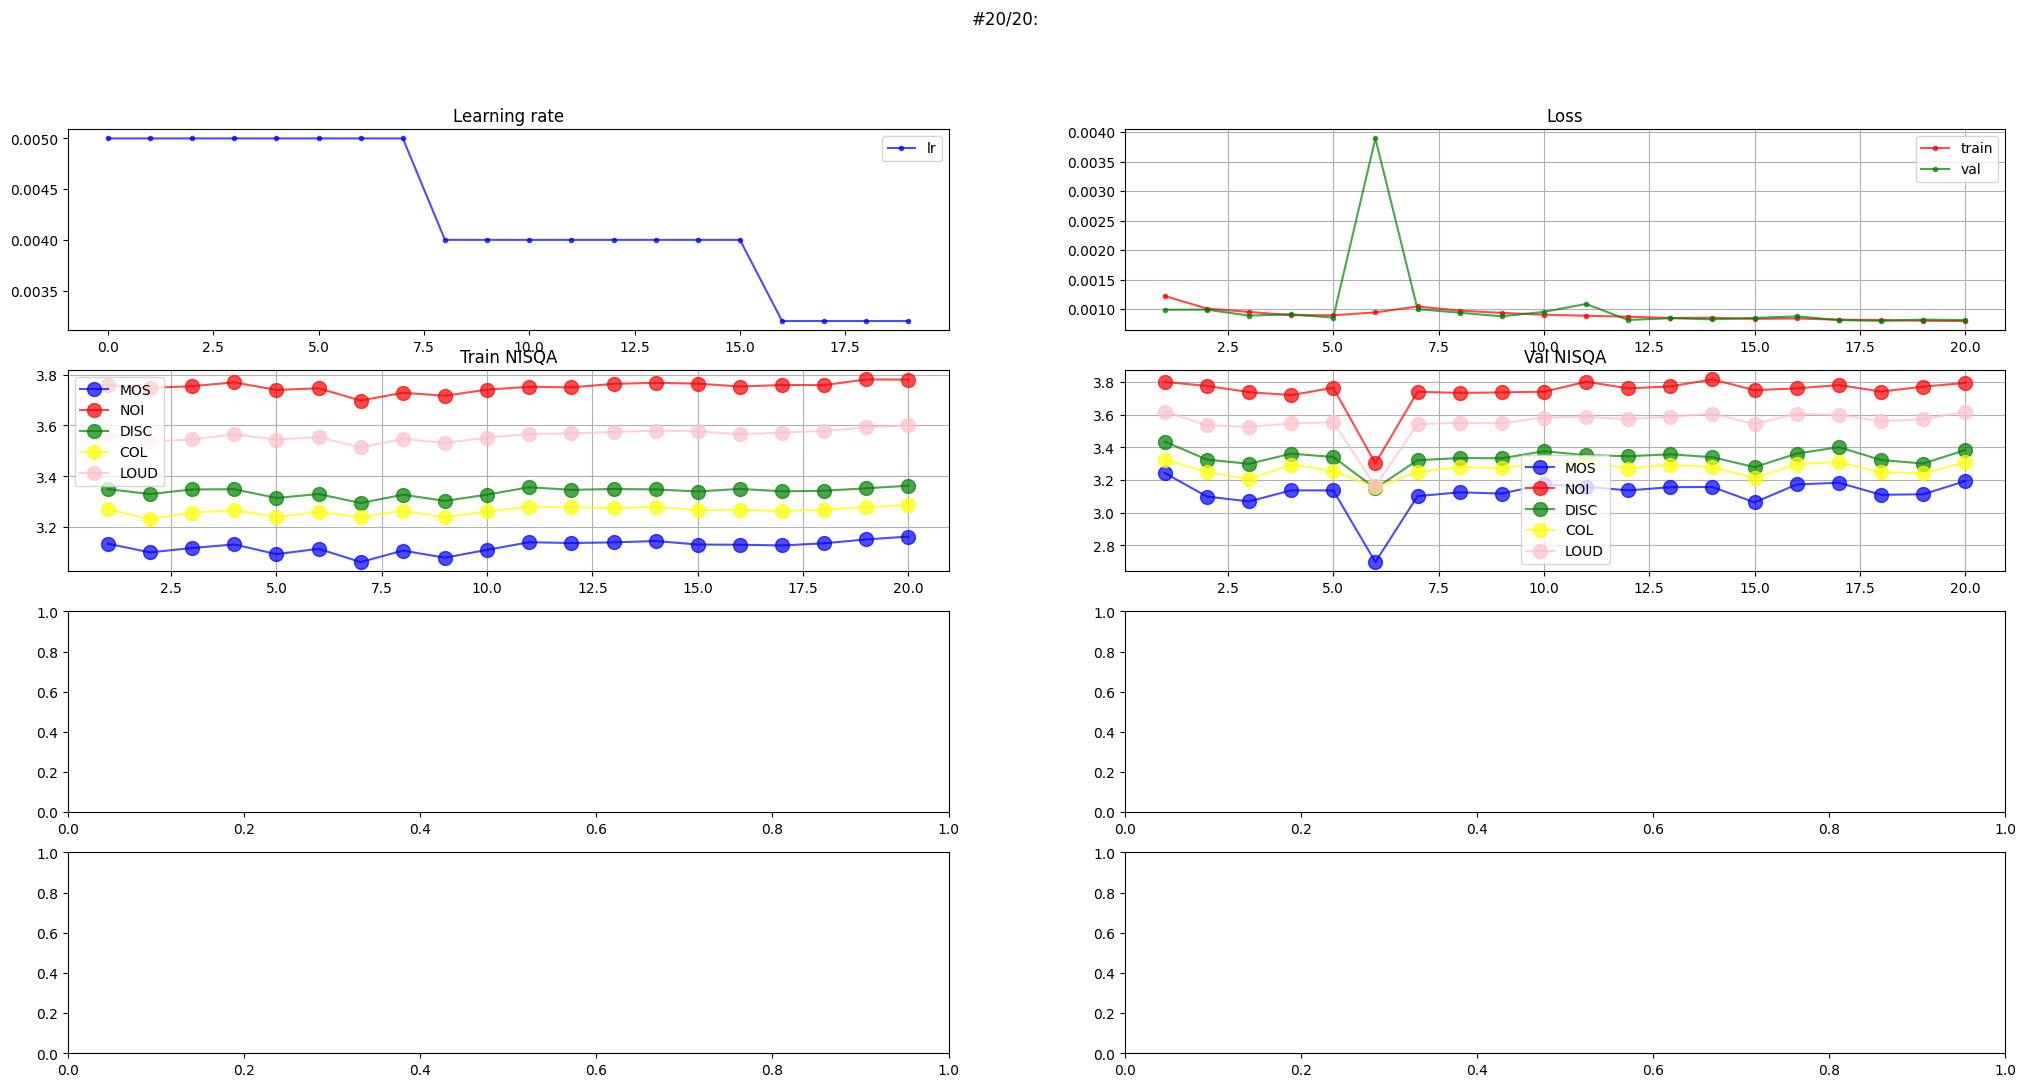

In [95]:
hh = 4
ww = 2
plt_ind = 1
fig, ax = plt.subplots(hh, ww, figsize=(25, 12))
fig.suptitle(f'#{state_d["epoch"]}/{state_d["epoch"]}:')


plt.subplot(hh, ww, plt_ind)
plt.title('Learning rate')
plt.plot(state_d["plots"]["learning rate"], 'b.-', label='lr', alpha=0.7)
plt.legend()
plt_ind += 1

plt.subplot(hh, ww, plt_ind)
plt.title('Loss')
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['train loss'], 'r.-', label='train', alpha=0.7)
plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['val loss'], 'g.-', label='val', alpha=0.7)
plt.grid()
plt.legend()
plt_ind += 1

# plt.subplot(hh, ww, plt_ind)
# plt.title('SRMR')
# plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['train SRMR'], 'r.-', label='train', alpha=0.7)
# plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['val SRMR'], 'g.-', label='val', alpha=0.7)
# plt.grid()
# plt.legend()
# plt_ind += 1

# plt.subplot(hh, ww, plt_ind)
# plt.title('STOI')
# plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['train STOI'], 'r.-', label='train', alpha=0.7)
# plt.plot(np.arange(1, state_d["epoch"] + 1), state_d["plots"]['val STOI'], 'g.-', label='val', alpha=0.7)
# plt.grid()
# plt.legend()
# plt_ind += 1

nisqa_plot = torch.cat(state_d["plots"]['train NISQA'])
# if len(nisqa_plot.shape) == 1:
#     nisqa_plot = nisqa_plot[None, :]
# print(nisqa_plot.shape)
plt.subplot(hh, ww, plt_ind)
plt.title('Train NISQA')
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 0], '.-', label='MOS', alpha=0.7, markersize=20, color="blue")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 1], '.-', label='NOI', alpha=0.7, markersize=20, color="red")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 2], '.-', label='DISC', alpha=0.7, markersize=20, color="green")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 3], '.-', label='COL', alpha=0.7, markersize=20, color="yellow")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 4], '.-', label='LOUD', alpha=0.7, markersize=20, color="pink")
plt.grid()
plt.legend()
plt_ind += 1

nisqa_plot = torch.cat(state_d["plots"]['val NISQA'], dim=0)
# if len(nisqa_plot.shape) == 1:
#     nisqa_plot = nisqa_plot[None, :]
plt.subplot(hh, ww, plt_ind)
plt.title('Val NISQA')
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 0], '.-', label='MOS', alpha=0.7, markersize=20, color="blue")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 1], '.-', label='NOI', alpha=0.7, markersize=20, color="red")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 2], '.-', label='DISC', alpha=0.7, markersize=20, color="green")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 3], '.-', label='COL', alpha=0.7, markersize=20, color="yellow")
plt.plot(np.arange(1, state_d["epoch"] + 1), nisqa_plot[:, 4], '.-', label='LOUD', alpha=0.7, markersize=20, color="pink")
plt.grid()
plt.legend()
plt_ind += 1

plt.show()

In [96]:
state_d["plots"]["train loss"]

[0.0012230961685053049,
 0.0010090221786299074,
 0.0009529223117003498,
 0.0008978542561541014,
 0.000896298011573362,
 0.0009445964941553818,
 0.0010448976354252074,
 0.0009747998645832916,
 0.0009362457614887746,
 0.000906016973903366,
 0.0008880042556634066,
 0.0008713486568456078,
 0.0008502665775499263,
 0.0008532710777725824,
 0.0008347333077484021,
 0.0008415595948358991,
 0.0008210991463673177,
 0.0008157446626640562,
 0.0008027307096786136,
 0.0007984820798817208]

In [97]:
state_d["plots"]["learning rate"][-1]

0.0032

In [98]:
def vorbis_window(winlen, device="cuda"):
    sq = torch.sin(torch.pi/2*(torch.sin(torch.pi/winlen*(torch.arange(winlen)-0.5))**2)).float()
    return sq

### Evaluation

In [99]:
input_sig, gt, gt_noise, gt_rir = train_dataset[1]

In [100]:
window = vorbis_window(512)

# input_sig_chunked = input_sig.unfold(-1, 16_000 * 2, 16_000 * 2)
# print(input_sig.shape, input_sig_chunked.shape)
# input_sig_chunked = input_sig_chunked.reshape(-1, input_sig_chunked.shape[-1])

spec = torch.stft(
            input_sig,
            n_fft=N_FFTS,
            hop_length=HOP_LENGTH,
            # onesided=True,
            win_length=512,
            window=window,
            return_complex=True,
            normalized=True,
            center=True
        ) 

In [101]:
gt_spec = torch.stft(
            gt,
            n_fft=N_FFTS,
            hop_length=HOP_LENGTH,
            # onesided=True,
            win_length=512,
            window=window,
            return_complex=True,
            normalized=True,
            center=True
        ) 

In [102]:
gt.shape, input_sig.shape, # input_sig_chunked.shape, spec.shape

(torch.Size([1, 240000]), torch.Size([1, 240000]))

In [103]:
fspen.eval()


input_spec_ = spec
abs_spectrum = spec.abs()
input_spec = torch.permute(torch.view_as_real(spec), dims=(0, 2, 3, 1))
batch, frames, channels, frequency = input_spec.shape

abs_spectrum = torch.permute(abs_spectrum, dims=(0, 2, 1))
abs_spectrum = torch.reshape(abs_spectrum, shape=(batch, frames, 1, frequency))
# h0 = [[torch.randn(1, batch * 32, 16 // 8,  ) for _ in range(8)]
#                for _ in range(3)]

hidden_state = [[torch.randn(1, input_spec.shape[0] * 32, 16 // 8, device=input_spec.device) for _ in range(8)] for _ in range(2)]

output, _ = fspen(input_spec, abs_spectrum, hidden_state)

output = torch.permute(output, dims=(0, 3, 1, 2))
output = torch.view_as_complex(output)

window = vorbis_window(N_FFTS)# .to(device)
# print(output_d.shape, input_spec.shape)
out_wave = torch.istft(output, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=N_FFTS,
                       window=window,
                       # onesided=True,
                       return_complex=False,
                       normalized=True,
                       center=True)


In [104]:
# with profiler.profile(with_stack=True, profile_memory=True) as prof:
#     _, _ = fspen(input_spec, abs_spectrum)

In [105]:
# print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total'))

In [106]:
out_wave = out_wave.reshape(-1)

In [107]:
# state_d = torch.load(os.path.join(CHKP_DIR, "fspen_chkp", "fspen_voicebank_subband_loss_small#0.pt"), weights_only=False)
# 
# fspen.load_state_dict(state_d["model_state_dict"])

In [108]:
# output, _ = fspen(input_spec, abs_spectrum)

# output = torch.permute(output, dims=(0, 3, 1, 2))
# output = torch.view_as_complex(output)

# window = vorbis_window(N_FFTS)# .to(device)
# # print(output_d.shape, input_spec.shape)
# out_wave_1 = torch.istft(output, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=N_FFTS,
#                        window=window,
#                        # onesided=True,
#                        return_complex=False,
#                        normalized=True,
#                        center=True)

# out_wave_1 = out_wave_1.reshape(-1)

In [109]:
from scipy.io.wavfile import write

# audio = sd.rec(int(duration * samplerate), samplerate=16_000, channels=1)
# sd.wait()  # дождаться окончания записи

write('input_sig_full.wav', SR, input_sig.cpu().detach().numpy()[0])
write('gt_full.wav', SR, gt.cpu().detach().numpy()[0])
write('output_full.wav', SR, out_wave.cpu().detach().numpy())
# write('output_full_1.wav', SR, out_wave_1.cpu().detach().numpy())

In [110]:
import time

def get_rtf(model, loader, device="cpu"):
    model.eval()
    
    model = model.to(device)
    
    inference_time = []
    model_time = []
    audio_dur = []
    with torch.no_grad():
        for signal in tqdm(loader):
            signal = signal.to(device)
            window = vorbis_window(N_FFTS).to(device)
            # print(signal.shape)
            time_start = time.time()
            spec = torch.stft(
                signal,
                n_fft=N_FFTS,
                hop_length=HOP_LENGTH,
                # onesided=True,
                win_length=512,
                window=window,
                return_complex=True,
                normalized=True,
                center=True
            ) 
            
            abs_spectrum = spec.abs()
            input_spec = torch.permute(torch.view_as_real(spec), dims=(0, 2, 3, 1))
            batch, frames, channels, frequency = input_spec.shape
            
            abs_spectrum = torch.permute(abs_spectrum, dims=(0, 2, 1))
            abs_spectrum = torch.reshape(abs_spectrum, shape=(batch, frames, 1, frequency))
            
            model_t = time.time()
            output, _ = model(input_spec, abs_spectrum)
            model_t = time.time() - model_t
            model_time.append(model_t)
    
            output = torch.permute(output, dims=(0, 3, 1, 2))
            output = torch.view_as_complex(output)
            
            window = vorbis_window(N_FFTS).to(device)
            _ = torch.istft(output, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=N_FFTS,
                                   window=window,
                                   # onesided=True,
                                   return_complex=False,
                                   normalized=True,
                                   center=True)
            end_time = time.time()
            inference_time.append(end_time - time_start)
            # print(signal.shape[-1] // SR)
            audio_dur.append(signal.shape[-1] / SR)
    
    inference_time = np.array(inference_time[1:])
    model_time = np.array(model_time[1:])
    audio_dur = np.array(audio_dur[1:])
    
    rtf = (audio_dur / inference_time).mean()
    rtf_model = (audio_dur / model_time).mean()
    print("Mean inference time:", inference_time.mean())
    print("Mean audio duration:", audio_dur.mean())
    print("RTF for inference:", rtf)
    print("RTF for model:", rtf_model)
    
    return rtf, rtf_model

In [111]:
def pad_sequence(batch):
    if not batch:
        return torch.zeros(0), torch.zeros(0)

    input_signal, target_signal, noise, rir = zip(*batch)
    # print(input_signal[0].shape)
    max_len_s = max(s.shape[-1] for s in input_signal)
    
    padded_input = torch.zeros(len(input_signal), max_len_s)
    
    for i, s in enumerate(input_signal):
        padded_input[i, :s.shape[-1]] = s

    return padded_input

def collate_fn(batch):
    
    padded_input = pad_sequence(batch)
        
    padded_input = padded_input.reshape(-1, padded_input.shape[-1])

    return padded_input

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False, collate_fn=collate_fn)

In [112]:
# get_rtf(fspen, test_dataloader, device="cuda")

In [113]:
# get_rtf(fspen, test_dataloader, device="cpu")

In [114]:
import yaml

from NISQA_s.src.core.model_torch import model_init
from NISQA_s.src.utils.process_utils import process

NISQA_PATH = "NISQA_s/config/nisqa_s.yaml"

with open(NISQA_PATH, 'r') as stream:
    nisqa_args = yaml.safe_load(stream)
nisqa_args["ms_n_fft"] = N_FFTS
nisqa_args["hop_length"] = HOP_LENGTH
nisqa_args["ms_win_length"] = N_FFTS
nisqa_args["ckp"] = nisqa_args["ckp"][3:]

nisqa, h0_nisqa, c0_nisqa = model_init(nisqa_args)

/home/zakhar/miniconda3/envs/ems_dereverb/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [32]:
from torchaudio.transforms import Resample


def get_metrics(model, loader, device="cpu"):
    model.eval()
    
    model = model.to(device)
    
    nisqa_scores = []
    srmr_scores = []
    with torch.no_grad():
        for signal in tqdm(loader):
            signal = signal.to(device)
            window = vorbis_window(N_FFTS).to(device)
    
            spec = torch.stft(
                signal,
                n_fft=N_FFTS,
                hop_length=HOP_LENGTH,
                # onesided=True,
                win_length=512,
                window=window,
                return_complex=True,
                normalized=True,
                center=True
            ) 
            
            abs_spectrum = spec.abs()
            input_spec = torch.permute(torch.view_as_real(spec), dims=(0, 2, 3, 1))
            batch, frames, channels, frequency = input_spec.shape
            
            abs_spectrum = torch.permute(abs_spectrum, dims=(0, 2, 1))
            abs_spectrum = torch.reshape(abs_spectrum, shape=(batch, frames, 1, frequency))
            
            hidden_state = [[torch.zeros(1, batch * 32, 16 // 8, device=input_spec.device) for _ in range(8)] for _ in range(2)]

            output, _ = model(input_spec, abs_spectrum, hidden_state)
    
            output = torch.permute(output, dims=(0, 3, 1, 2))
            output = torch.view_as_complex(output)
            
            window = vorbis_window(N_FFTS).to(device)
            output = torch.istft(output, n_fft=N_FFTS, hop_length=HOP_LENGTH, win_length=N_FFTS,
                                   window=window,
                                   # onesided=True,
                                   return_complex=False,
                                   normalized=True,
                                   center=True)
            
            resampler = Resample(SR, 48_000)
            output = resampler(output)
            
            nisqa_score, _, _ = process(output.detach().cpu(), 48_000, nisqa, h0_nisqa, c0_nisqa, nisqa_args)
            # srmr_score = srmr(output.detach())
            
            nisqa_scores.append(nisqa_score[0])
            # srmr_scores.append(srmr_score)

    result = {"nisqa": nisqa_scores}
        
    return result

In [33]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False, collate_fn=collate_fn)

In [34]:
metrics = get_metrics(fspen, test_dataloader, device="cuda")

100%|██████████| 13272/13272 [11:57<00:00, 18.49it/s]


In [36]:
# torch.tensor(metrics["srmr"]).mean()

In [37]:
torch.vstack(metrics["nisqa"]).mean(dim=0)

tensor([2.737, 3.138, 3.141, 3.316, 3.339])